### Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from math import sqrt

def rmse(predictions, targets):
    return sqrt(mse(predictions, targets))

from IPython.core.display import HTML
import imgkit

# 1. Data Prep

### 1.1 Get Data

In [3]:
# Read the csv and feed it into the variable xc
data = pd.read_csv("https://raw.githubusercontent.com/Iandrewburg/Assignment_1/main/morg-2014-emp.csv")


### 1.2 Filter the dataset for healthcare practitioners

In [4]:
# Filter dataset for healthcare practitioners
data = data.loc[((data["occ2012"] >= 3000) & (data["occ2012"] <= 3540))]


In [5]:
data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
10,25,620910090003769,January,AL,3851.5450,1800.00,40,43,1,NaN,...,2,4,"Native, Born In US",63,Pharmacies and drug stores (44611),3050,"Private, For Profit",No,No,Employed-At Work
33,60,7087505071191,January,AL,3712.0546,1171.60,40,41,1,NaN,...,0,0,"Native, Born In US",63,Business support services (5614),3510,"Private, For Profit",No,No,Employed-At Work
37,77,97953206049188,January,AL,3414.1067,1730.76,60,44,1,NaN,...,0,0,"Native, Born In US",63,Home health care services (6216),3255,"Private, For Profit",No,No,Employed-Absent
42,89,130003560100156,January,AL,3296.7986,2884.61,60,45,1,NaN,...,2,10,"Native, Born In US",63,Offices of physicians (6211),3060,"Private, For Profit",No,No,Employed-At Work
71,166,42510310991895,January,AL,3322.0487,618.75,45,40,1,NaN,...,0,0,"Native, Born In US",63,Hospitals (622),3320,"Private, For Profit",No,No,Employed-At Work


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9208 entries, 10 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9208 non-null   int64  
 1   hhid        9208 non-null   int64  
 2   intmonth    9208 non-null   object 
 3   stfips      9208 non-null   object 
 4   weight      9208 non-null   float64
 5   earnwke     9208 non-null   float64
 6   uhours      9208 non-null   int64  
 7   grade92     9208 non-null   int64  
 8   race        9208 non-null   int64  
 9   ethnic      586 non-null    float64
 10  age         9208 non-null   int64  
 11  sex         9208 non-null   int64  
 12  marital     9208 non-null   int64  
 13  ownchild    9208 non-null   int64  
 14  chldpres    9208 non-null   int64  
 15  prcitshp    9208 non-null   object 
 16  state       9208 non-null   object 
 17  ind02       9208 non-null   object 
 18  occ2012     9208 non-null   int64  
 19  class       9208 non-null   o

### 1.3 Data Cleaning

In [7]:
# focusing on the variables being used in this study
data["sex"] = data["sex"].fillna("Missing")
data["earnwke"] = data["earnwke"].fillna("Missing")
data["uhours"] = data["uhours"].fillna("Missing")
data["lfsr94"] = data["lfsr94"].fillna("Missing")
data["marital"] = data["marital"].fillna("Missing")
data["grade92"] = data["grade92"].fillna("Missing")
data["age"] = data["age"].fillna("Missing")
data["chldpres"] = data["chldpres"].fillna("Missing")


# 2. EDA

### 2.1 Frequency table for number of children

In [8]:
# Frequency table for chldpres
freq_chldpres = data.groupby("chldpres").agg(frequency=("chldpres", "size"))
freq_chldpres["percent"] = round(freq_chldpres["frequency"] / sum(freq_chldpres["frequency"]) * 100, 3)
freq_chldpres["cumulative_percent"] = np.cumsum(freq_chldpres["percent"])
print("Frequency Table for chldpres:")
freq_chldpres

Frequency Table for chldpres:


,frequency,percent,cumulative_percent
chldpres,,,
0,5347,58.069,58.069
1,457,4.963,63.032
2,272,2.954,65.986
3,949,10.306,76.292
4,634,6.885,83.177
5,262,2.845,86.022
6,130,1.412,87.434
7,15,0.163,87.597
8,382,4.149,91.746


### 2.2 Frequency table for marital status

In [9]:
# Frequency table for marital
freq_marital = data.groupby("marital").agg(frequency=("marital", "size"))
freq_marital["percent"] = round(freq_marital["frequency"] / sum(freq_marital["frequency"]) * 100, 3)
freq_marital["cumulative_percent"] = np.cumsum(freq_marital["percent"])
print("Frequency Table for marital:")
freq_marital

Frequency Table for marital:


,frequency,percent,cumulative_percent
marital,,,
1,5733,62.261,62.261
2,60,0.652,62.913
3,100,1.086,63.999
4,132,1.434,65.433
5,1048,11.381,76.814
6,185,2.009,78.823
7,1950,21.177,100.000


### 2.3 Frequency table for working status

In [10]:
# Frequency table for lfsr94
freq_lfsr94 = data.groupby("lfsr94").agg(frequency=("lfsr94", "size"))
freq_lfsr94["percent"] = round(freq_lfsr94["frequency"] / sum(freq_lfsr94["frequency"]) * 100, 3)
freq_lfsr94["cumulative_percent"] = np.cumsum(freq_lfsr94["percent"])
print("Frequency Table for lfsr94:")
freq_lfsr94

Frequency Table for lfsr94:


,frequency,percent,cumulative_percent
lfsr94,,,
Employed-Absent,358,3.888,3.888
Employed-At Work,8850,96.112,100.000


### 2.4 Frequency table for level of education

In [11]:
# Frequency table for grade92
freq_grade92 = data.groupby("grade92").agg(frequency=("grade92", "size"))
freq_grade92["percent"] = round(freq_grade92["frequency"] / sum(freq_grade92["frequency"]) * 100, 3)
freq_grade92["cumulative_percent"] = np.cumsum(freq_grade92["percent"])
print("Frequency Table for grade92:")
freq_grade92

Frequency Table for grade92:


,frequency,percent,cumulative_percent
grade92,,,
31,3,0.033,0.033
32,2,0.022,0.055
33,2,0.022,0.077
34,2,0.022,0.099
35,2,0.022,0.121
36,2,0.022,0.143
37,14,0.152,0.295
38,9,0.098,0.393
39,609,6.614,7.007


### 2.5 Frequency table for gender

Transformed to a binary variable for female to make more clear

In [12]:
# Frequency table for gender
data["female"] = (data["sex"] == 2).astype(int) # gender dummy
freq_gender = data.groupby("female").agg(frequency=("female", "size"))
freq_gender["percent"] = round(freq_gender["frequency"] / sum(freq_gender["frequency"]) * 100, 3)
freq_gender["cumulative_percent"] = np.cumsum(freq_gender["percent"])
print("Frequency Table for Gender:")
freq_gender

Frequency Table for Gender:


,frequency,percent,cumulative_percent
female,,,
0,1988,21.59,21.59
1,7220,78.41,100.00


### 2.6 Dummy Variable Transformations

In [13]:
# currently working dummy
data["working"] = (data["lfsr94"] == "Employed-At Work").astype(int)

# marriage dummies
data["married"] = ((data["marital"] == 1) | (data["marital"] == 2)).astype(int)
data["divorced"] = ((data["marital"] == 3) & (data["marital"] == 5)).astype(int)
data["wirowed"] = (data["marital"] == 4).astype(int)
data["nevermar"] = (data["marital"] == 7).astype(int)

# children dummies
data["child0"] = (data["chldpres"] == 0).astype(int)
data["child1"] = (data["chldpres"] == 1).astype(int)
data["child2"] = (data["chldpres"] == 2).astype(int)
data["child3"] = (data["chldpres"] == 3).astype(int)
data["child4pl"] = (data["chldpres"] >= 4).astype(int)

# wage trasnformaton - w represents earnings per hour
data["w"] = data["earnwke"] / data["uhours"] # hourly earnings
data['w'] = pd.to_numeric(data['w'], errors='coerce')
data["lnw"] = np.log(data["w"]) 

# age transformation dummies
data["agesq"] = np.power(data["age"], 2)
data["agecu"] = np.power(data["age"], 3)
data["agequ"] = np.power(data["age"], 4)

# education dummies
data['grade92'] = pd.to_numeric(data['grade92'], errors='coerce')
data["university"] = (data["grade92"] > 40).astype(int)
data["ed_MA"] = (data["grade92"] == 44).astype(int)
data["ed_Profess"] = (data["grade92"] == 45).astype(int)
data["ed_Phd"] = (data["grade92"] == 46).astype(int)

data.shape

(9208, 43)

### 2.7 Keep variables being used in the dataframe

Dropping all other variables that we are not using

In [14]:
# List of columns to keep
columns_to_keep = [
    "female", "sex",
    "working", "lfsr94",
    "marital", "married", "divorced", "wirowed", "nevermar",
    "chldpres", "child0", "child1", "child2", "child3", "child4pl",
    "earnwke", "uhours", "w", "lnw",
    "age", "agesq", "agecu", "agequ",
    "grade92", "university", "ed_MA", "ed_Profess", "ed_Phd"
]
data = data[columns_to_keep]

data.shape


(9208, 28)

In [15]:
data

,female,sex,working,lfsr94,marital,married,divorced,wirowed,nevermar,chldpres,...,lnw,age,agesq,agecu,agequ,grade92,university,ed_MA,ed_Profess,ed_Phd
10,1,2,1,Employed-At Work,1,1,0,0,0,4,...,3.806662,50,2500,125000,6250000,43,1,0,0,0
33,1,2,1,Employed-At Work,5,0,0,0,0,0,...,3.377246,61,3721,226981,13845841,41,1,0,0,0
37,1,2,0,Employed-Absent,1,1,0,0,0,0,...,3.361971,52,2704,140608,7311616,44,1,1,0,0
42,0,1,1,Employed-At Work,1,1,0,0,0,10,...,3.872800,47,2209,103823,4879681,45,1,0,1,0
71,1,2,1,Employed-At Work,1,1,0,0,0,0,...,2.621039,58,3364,195112,11316496,40,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149201,1,2,1,Employed-At Work,3,0,0,0,0,0,...,4.278266,52,2704,140608,7311616,45,1,0,1,0
149242,1,2,1,Employed-At Work,1,1,0,0,0,3,...,3.178054,32,1024,32768,1048576,42,1,0,0,0
149252,1,2,1,Employed-At Work,7,0,0,0,1,0,...,2.088773,20,400,8000,160000,40,0,0,0,0
149290,1,2,1,Employed-At Work,1,1,0,0,0,0,...,2.397895,59,3481,205379,12117361,45,1,0,1,0


### 2.8 Descriptive Statistics

In [16]:
descriptive_stats = data[[
    "female",
    "working",
    "married", "divorced", "wirowed", "nevermar",
    "child0", "child1", "child2", "child3", "child4pl",
    "earnwke", "uhours", "w", "lnw",
    "age", "agesq", "agecu", "agequ",
    "university", "ed_MA", "ed_Profess", "ed_Phd"
    ]].describe().T

descriptive_stats_rounded = descriptive_stats.round(2)
descriptive_stats_rounded


,count,mean,std,min,25%,50%,75%,max
female,9208.0,0.78,0.41,0.00,1.00,1.00,1.00,1.00
working,9208.0,0.96,0.19,0.00,1.00,1.00,1.00,1.00
married,9208.0,0.63,0.48,0.00,0.00,1.00,1.00,1.00
divorced,9208.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
wirowed,9208.0,0.01,0.12,0.00,0.00,0.00,0.00,1.00
nevermar,9208.0,0.21,0.41,0.00,0.00,0.00,0.00,1.00
child0,9208.0,0.58,0.49,0.00,0.00,1.00,1.00,1.00
child1,9208.0,0.05,0.22,0.00,0.00,0.00,0.00,1.00
child2,9208.0,0.03,0.17,0.00,0.00,0.00,0.00,1.00
child3,9208.0,0.10,0.30,0.00,0.00,0.00,0.00,1.00


# 3. Distribution Visualizations

### 3.1 Hourly Wage Distribution Histogram

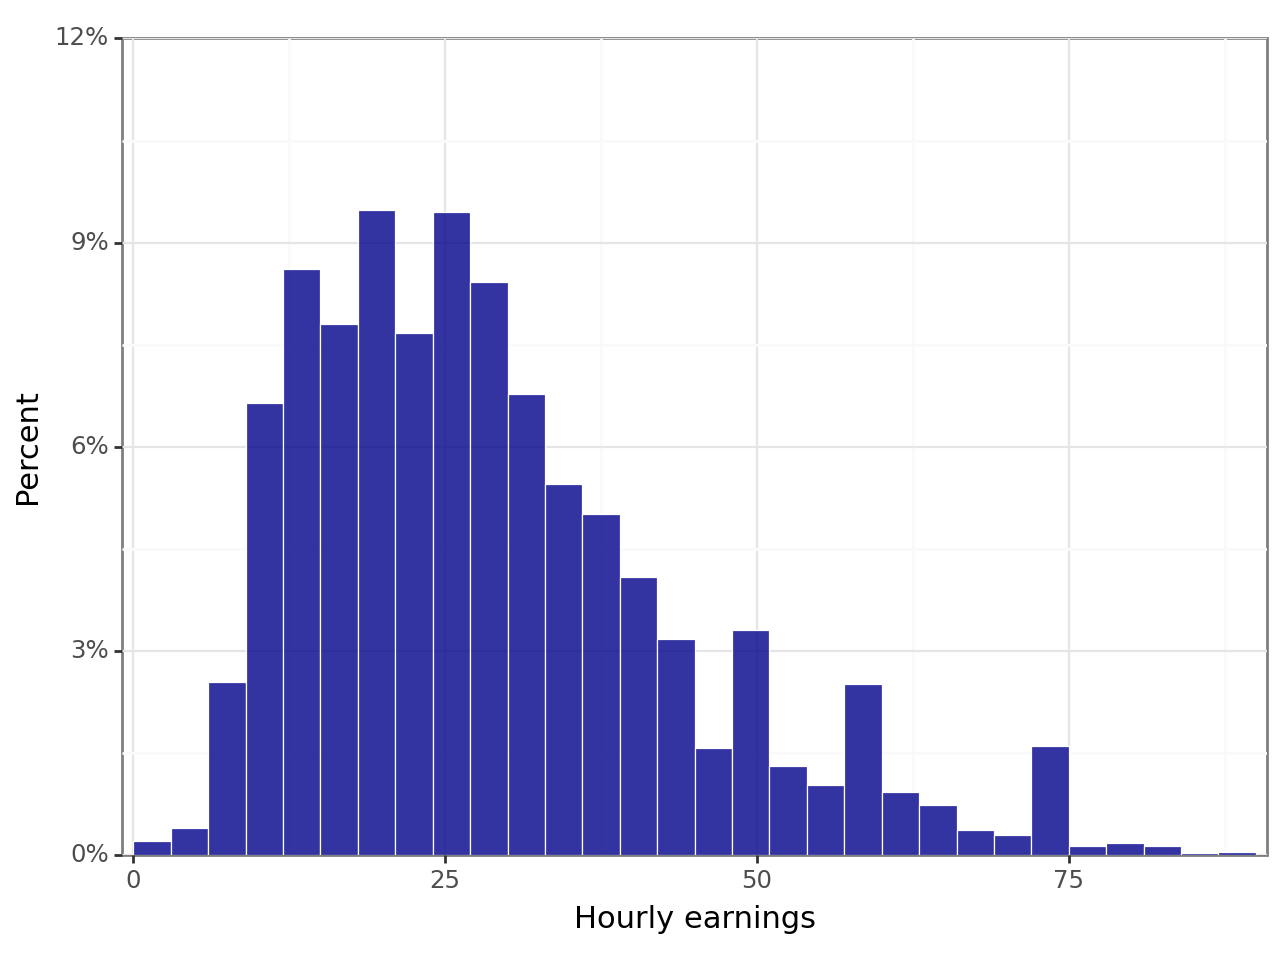

<Figure Size: (640 x 480)>

In [17]:
(
    ggplot(data, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


### 3.2 Distribution Histogram of log hourly wages

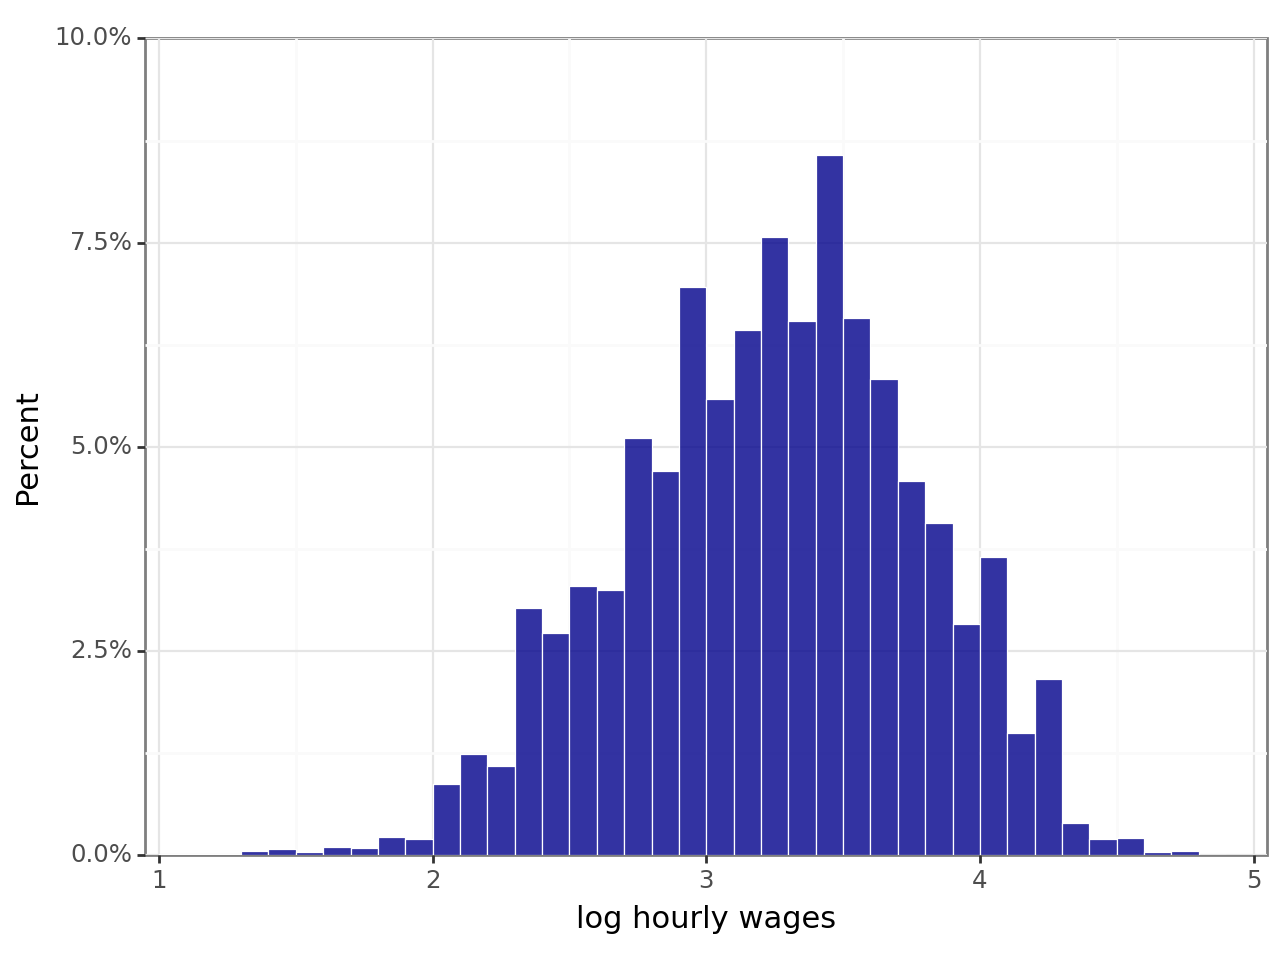

<Figure Size: (640 x 480)>

In [18]:
(
    ggplot(data, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)


### 3.3 Lowess Wages Across Levels of Education

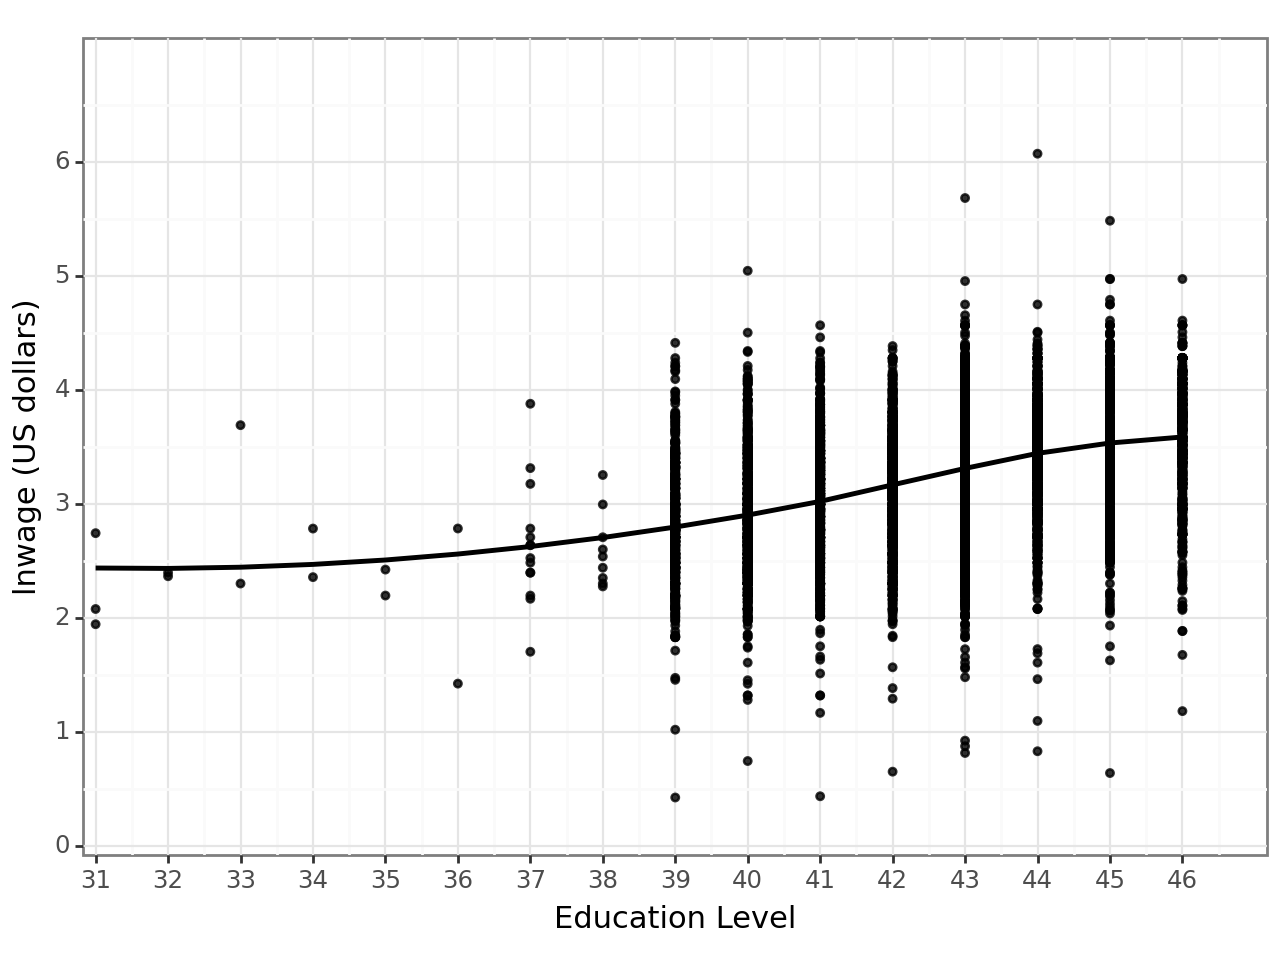

In [19]:
plot = ggplot(data, aes(x="grade92", y="lnw")) + geom_point(
    size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, size=1, span=0.9) + labs(
    x="Education Level", y="lnwage (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(31, 47), breaks=np.arange(31, 47, 1)
)

print(plot)


### 3.4 Lowess of Wages Across Marital Status

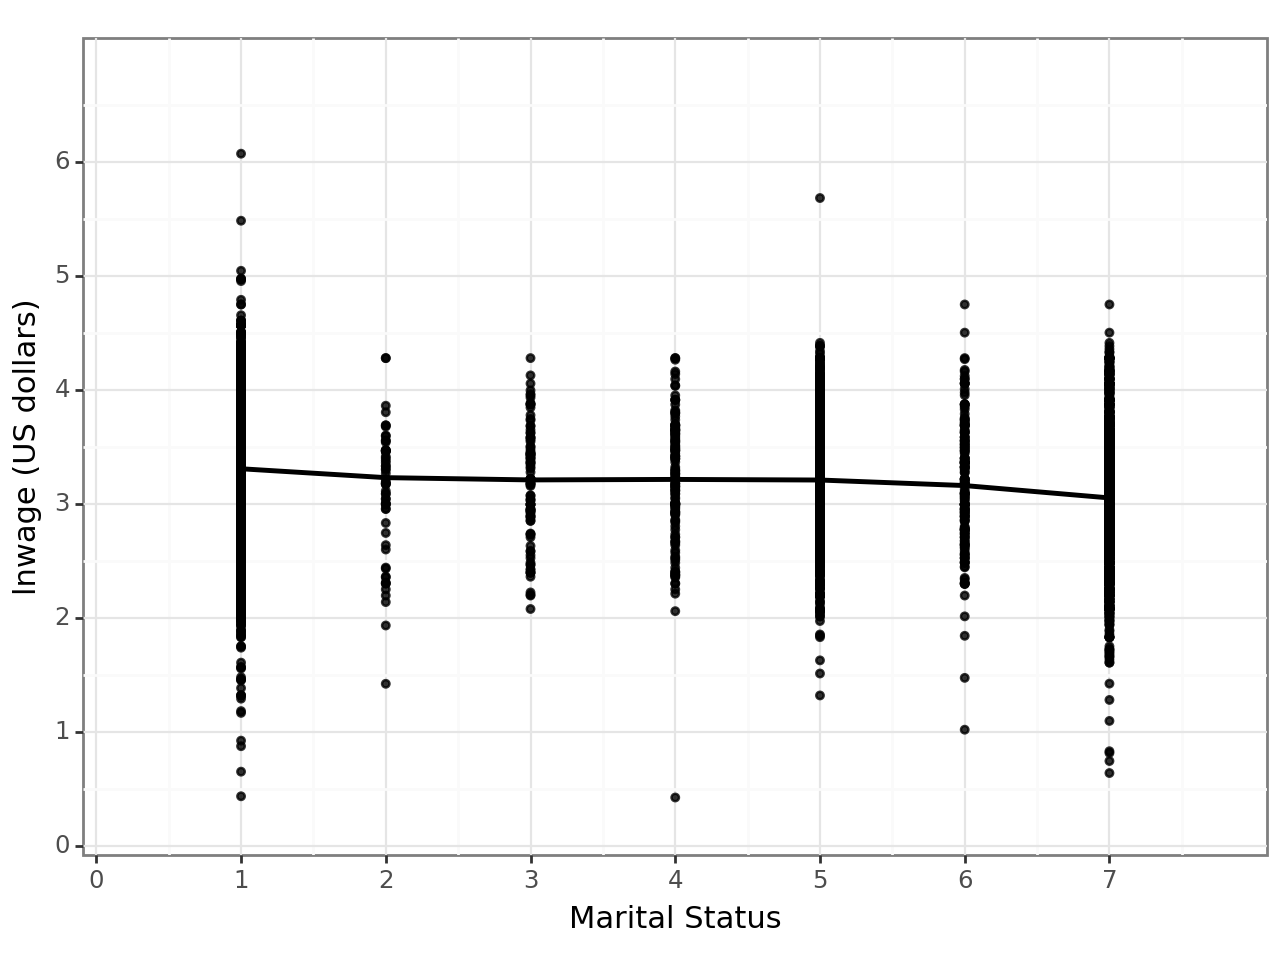

In [20]:
plot = ggplot(data, aes(x="marital", y="lnw")) + geom_point(
    size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, size=1, span=0.9) + labs(
    x="Marital Status", y="lnwage (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 8), breaks=np.arange(0, 8, 1)
)

print(plot)


### 3.5 Lowess of Wages Across Children Present

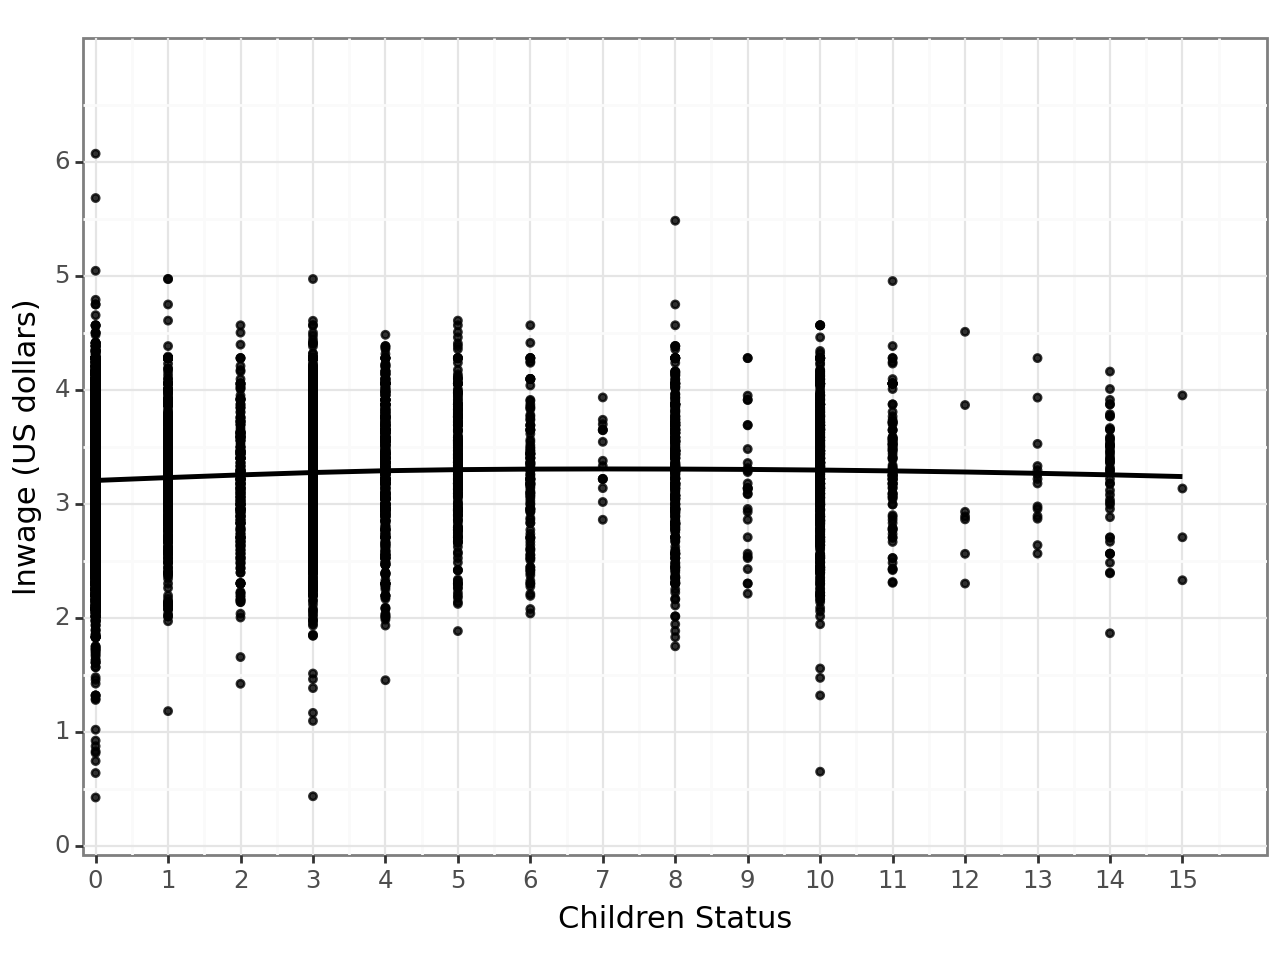

In [21]:
plot = ggplot(data, aes(x="chldpres", y="lnw")) + geom_point(
    size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, size=1, span=0.9) + labs(
    x="Children Status", y="lnwage (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 16), breaks=np.arange(0, 16, 1)
)

print(plot)


### 3.6 Lowess of Wages Across Age

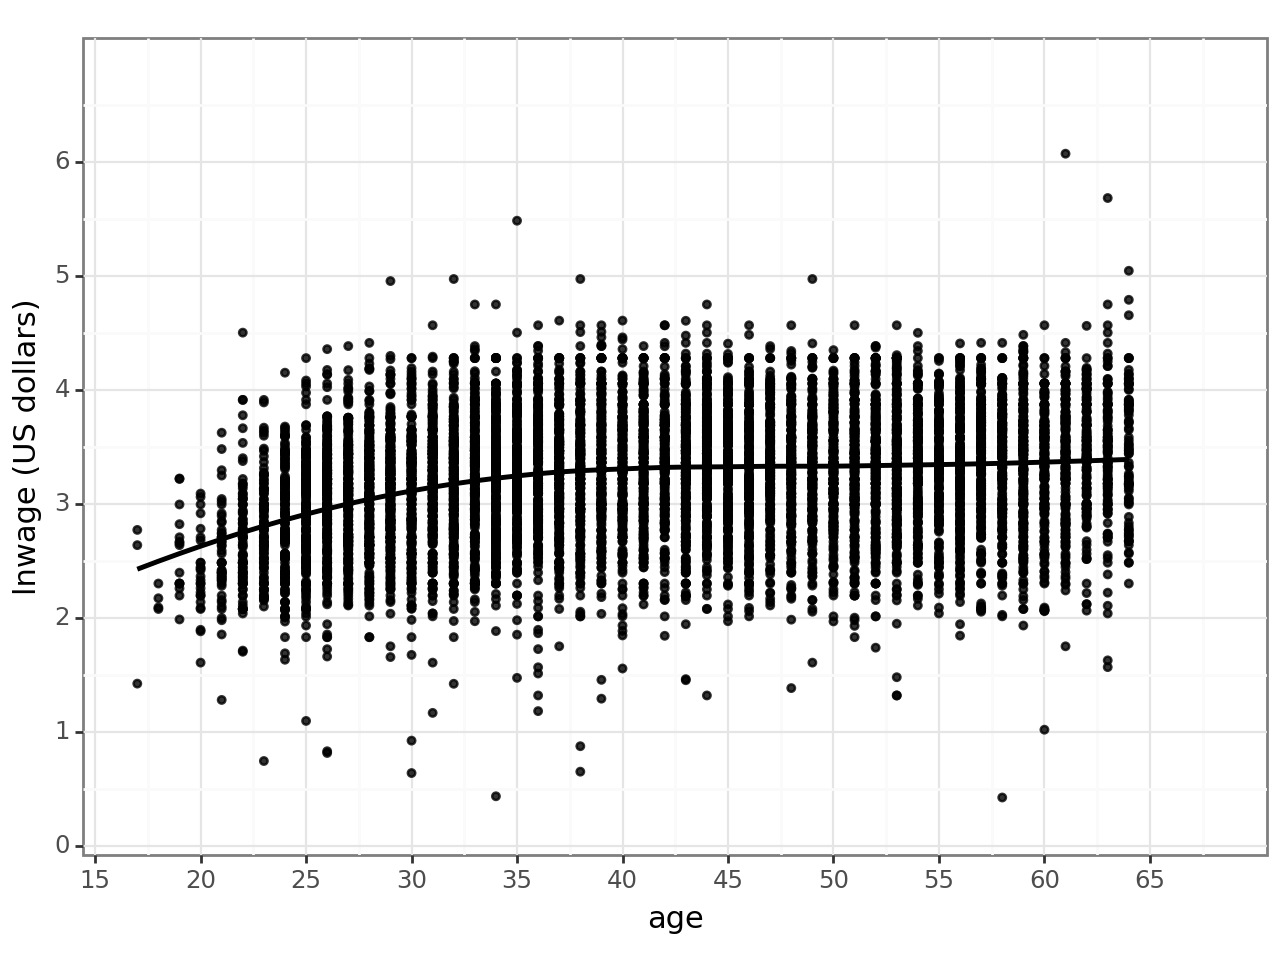

In [22]:
plot = ggplot(data, aes(x="age", y="lnw")) + geom_point(
    size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, size=1, span=0.9) + labs(
    x="age", y="lnwage (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(15, 70), breaks=np.arange(15, 70, 5)
)

print(plot)


# 4. Linear Regressions

### 4.1 Lowess of log hourly wages on age

In [23]:
lowess = sm.nonparametric.lowess
y_hat_lowess = lowess(data.lnw, data.age)

In [24]:
y_hat_lowess[0:10]

array([[17.        ,  2.6644494 ],
       [17.        ,  2.6644494 ],
       [17.        ,  2.6644494 ],
       [18.        ,  2.7003829 ],
       [18.        ,  2.7003829 ],
       [18.        ,  2.7003829 ],
       [18.        ,  2.7003829 ],
       [19.        ,  2.73584229],
       [19.        ,  2.73584229],
       [19.        ,  2.73584229]])

In [25]:
y_hat_lowess = [x[1] for x in y_hat_lowess]
y_hat_lowess[0:10]

[2.664449399775249,
 2.664449399775249,
 2.664449399775249,
 2.7003829032065267,
 2.7003829032065267,
 2.7003829032065267,
 2.7003829032065267,
 2.735842290613986,
 2.735842290613986,
 2.735842290613986]

### 4.1 Linear Regression Model 1: age

In [26]:
reg1 = smf.ols("lnw ~ age", data=data).fit(cov_type="HC0")
stargazer.Stargazer([reg1])

### 4.2 Regression Models 1-4

Expanding by adding new explanatory variables as well as interaction variables

In [27]:
# Model 1: Simple model
reg1 = smf.ols("lnw ~ age", data=data).fit(cov_type="HC0")

# Model 2: Adds more demographic variables
reg2 = smf.ols("lnw ~ age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl", data=data).fit(cov_type="HC0")

# Model 3: Adds education variables
reg3 = smf.ols("lnw ~ age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl + university + ed_MA + ed_Profess + ed_Phd", data=data).fit(cov_type="HC0")

# Model 4: Adds interaction terms (e.g., age and education level interactions)
reg4 = smf.ols("lnw ~ age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl + university + ed_MA + ed_Profess + ed_Phd + age:university + age:ed_MA + age:ed_Profess + age:ed_Phd", data=data).fit(cov_type="HC0")

models = [reg1, reg2, reg3, reg4]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)
    



Regression: reg1
                            OLS Regression Results                            
Dep. Variable:                    lnw   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     362.4
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           2.74e-79
Time:                        17:37:00   Log-Likelihood:                -8347.4
No. Observations:                9208   AIC:                         1.670e+04
Df Residuals:                    9206   BIC:                         1.671e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7880      0.023  

### 4.3 Predictive Plot for Age and Log Hourly Wages

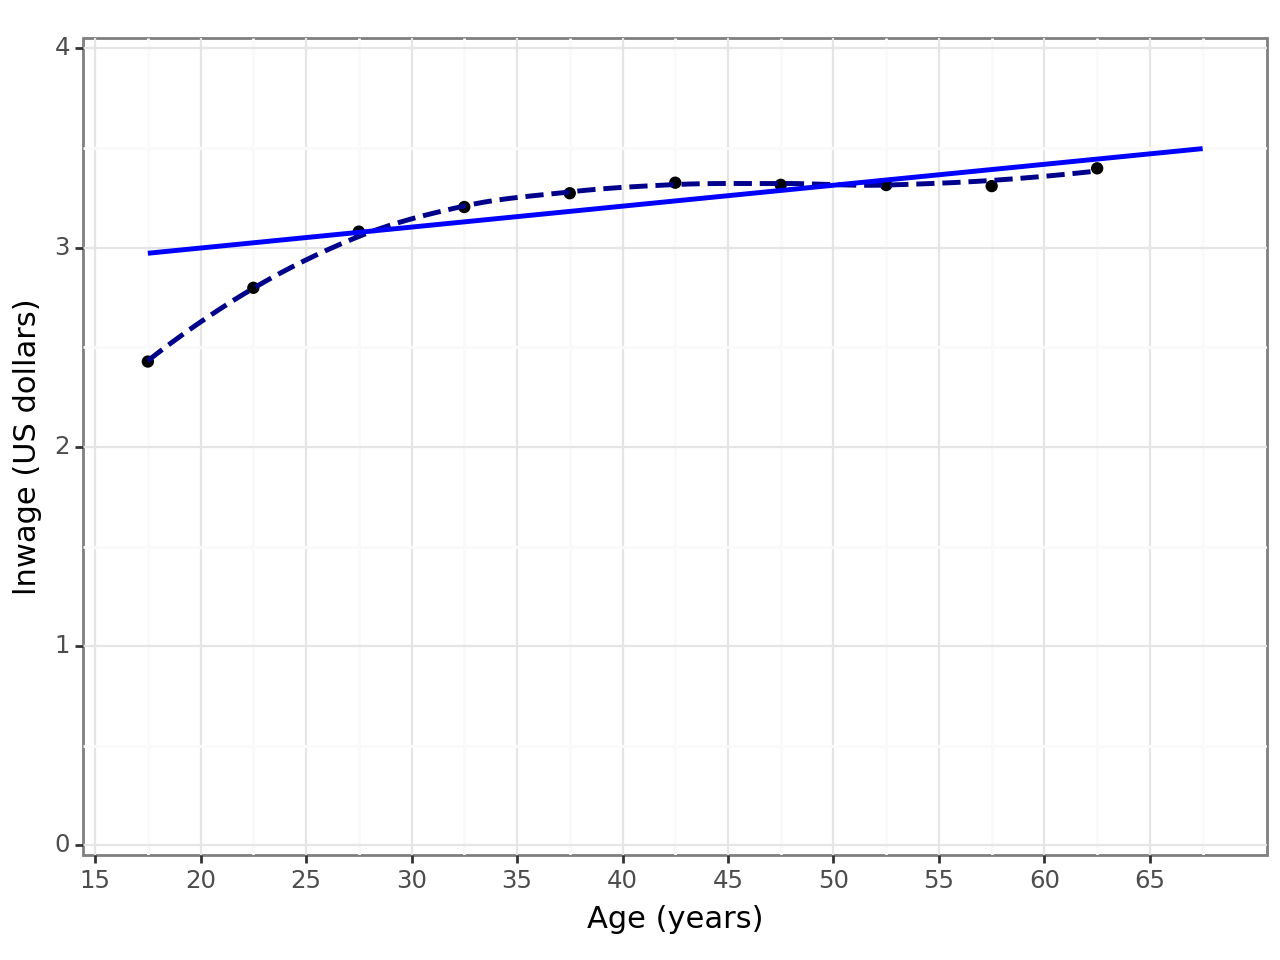

In [28]:
# Bin the 'age' variable
data['age_bin'] = pd.cut(data['age'], bins=np.arange(15, 75, 5))

# Calculate the mean of 'lnw' for each age bin
age_bin_means = data.groupby('age_bin')['lnw'].mean().reset_index()

# Calculate the mid-point of each age bin for plotting
age_bin_means['age_bin_mid'] = age_bin_means['age_bin'].apply(lambda x: x.mid).astype(float)

predict_df = pd.DataFrame({'age': age_bin_means['age_bin_mid']})
age_bin_means['predicted_lnw'] = reg1.predict(predict_df)

# Plot the Lowess smooth line based on the 5-year binned means
plot = ggplot(age_bin_means, aes(x='age_bin_mid', y='lnw')) + geom_point() + geom_smooth(
    aes(x='age_bin_mid', y='lnw'), method='loess', colour='darkblue', linetype='dashed', se=False, size=1
) + geom_line(
    aes(x='age_bin_mid', y='predicted_lnw'), colour="blue", size=1
) + labs(
    x='Age (years)', y='lnwage (US dollars)'
) + theme_bw() + scale_x_continuous(
    expand=(0.01, 0.01), limits=(15, 70), breaks=np.arange(15, 70, 5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 4), breaks=np.arange(int(data['lnw'].min()), int(data['lnw'].max()) + 1, 1)
)

print(plot)


### 4.4 Stargazer with RSME and BIC

In [35]:
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4])


# RMSE
rmse_values = [round(rmse(x.fittedvalues, data.lnw), 3) for x in [reg1, reg2, reg3, reg4]]
sg.add_line('RSME', rmse_values, location=stargazer.LineLocation.FOOTER_BOTTOM)

# BIC
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4]]
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)


# Set the order of covariates
sg.covariate_order(["Intercept", "age", "agesq", "age:university", "age:ed_MA", 
                    "age:ed_Profess", "age:ed_Phd", "female", "working", "married", 
                    "divorced", "wirowed", "nevermar", "child0", "child1", "child2", 
                    "child3", "child4pl", "university", "ed_MA", "ed_Profess", "ed_Phd"])

# Rename the covariates to more appropriate names for display
covariate_labels = {
    'Intercept': 'Constant', 
    'age': 'Age', 
    'agesq': 'Age^2', 
    'age:university': 'Age × University', 
    'age:ed_MA': 'Age × Masters', 
    'age:ed_Profess': 'Age × Prof Degree', 
    'age:ed_Phd': 'Age × PhD', 
    'female': 'Female', 
    'working': 'Working', 
    'married': 'Married', 
    'divorced': 'Divorced', 
    'wirowed': 'Widowed', 
    'nevermar': 'Never Married', 
    'child0': 'No Children', 
    'child1': '1 Child', 
    'child2': '2 Children', 
    'child3': '3 Children', 
    'child4pl': '4+ Children', 
    'university': 'University', 
    'ed_MA': 'Masters', 
    'ed_Profess': 'Prof Degree', 
    'ed_Phd': 'PhD'
}
sg.rename_covariates(covariate_labels)
sg

**Interpretation** 

Of the four models, model 4 has the highest R-Squared, and the lowest BIC; however, this does not mean it is the best model. This is because the difference between model 4 and model 3 is very miniscule. As Model 3 has much larger R-Squared than models 1 and 2, Model 3 would be the best model to go with as it has less variables than model 4, and is therefore less complex and easier to interpret. 

### 4.5 Export stargazer as an HTML file

In [40]:
# Using the sg variable from the previous code
html_code = sg.render_html()
display(HTML(html_code))

# save the HTML to a file
with open('stargazer_table.html', 'w', encoding='utf-8') as f:
    f.write(html_code)

# displayed the regression table again to verify it is what we are looking for

### 4.5 K-Fold Cross-validation 

In [33]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [34]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [35]:
cv1 = cv_reg("lnw~age", data, k, "HC0")
cv2 = cv_reg("lnw~age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl", data, k, "HC0")
cv3 = cv_reg("lnw~age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl + university + ed_MA + ed_Profess + ed_Phd", data, k, "HC0")
cv4 = cv_reg("lnw~age + agesq + female + working + married + divorced + wirowed + nevermar + child0 + child1 + child2 + child3 + child4pl + university + ed_MA + ed_Profess + ed_Phd + age*university + age*ed_MA + age*ed_Profess + age*ed_Phd", data, k, "HC0")

cv_list = [cv1, cv2, cv3, cv4]

In [36]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,0.604223,0.591618,0.562482,0.562305
Fold2,0.601318,0.591268,0.560178,0.559883
Fold3,0.573543,0.562438,0.529292,0.529043
Fold4,0.616165,0.604750,0.574341,0.573927
Average,0.598812,0.587518,0.556573,0.556290


**Interpretation**

This K-Fold Cross Validation of the RSME was performed to analyze the performance of the data on a more granulated level for the purpose of machine learning applicability. The results show that Model 3 and 4 have the lowest values. They are very close in value, so Model 3 is the best model here since it has the lower number of variables included in its model. 

# 5. Prediction 

In [37]:
data = data[
    [
    "married", "divorced", "wirowed", "nevermar",
    "working", "female",
    "child0", "child1", "child2", "child3", "child4pl",
    "lnw",
    "age", "agesq",
    "university", "ed_MA", "ed_Profess", "ed_Phd"
    ]
]

In [38]:
data.dtypes

married         int32
divorced        int32
wirowed         int32
nevermar        int32
working         int32
female          int32
child0          int32
child1          int32
child2          int32
child3          int32
child4pl        int32
lnw           float64
age             int64
agesq           int64
university      int32
ed_MA           int32
ed_Profess      int32
ed_Phd          int32
dtype: object

In [39]:
new = pd.DataFrame(pd.Series({
    "married":1,
    "divorced":0, 
    "wirowed":0, 
    "nevermar":0,
    "working":1,
    "female":1,
    "child0":1, 
    "child1":0, 
    "child2":0, 
    "child3":0, 
    "child4pl":0, 
    "lnw":np.nan,
    "age":42, 
    "agesq":42**2,
    "university":1,
    "ed_MA":1, 
    "ed_Profess":0, 
    "ed_Phd":0
})).T
new

,married,divorced,wirowed,nevermar,working,female,child0,child1,child2,child3,child4pl,lnw,age,agesq,university,ed_MA,ed_Profess,ed_Phd
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,42.0,1764.0,1.0,1.0,0.0,0.0


In [40]:
#turning off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [41]:
reg1.resid.describe()

count   9208.000
mean      -0.000
std        0.599
min      -11.712
25%       -0.346
50%        0.042
75%        0.372
max        2.641
dtype: float64

In [42]:
p1=reg1.get_prediction(new).summary_frame()
p1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.229,0.006,3.217,3.241,2.055,4.403


In [43]:
(reg3.fittedvalues-data.lnw).describe()

count   9208.000
mean      -0.000
std        0.557
min       -2.549
25%       -0.333
50%       -0.039
75%        0.295
max       12.127
dtype: float64

In [44]:
p2=reg3.get_prediction(new).summary_frame()
p2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.454,0.019,3.418,3.491,2.361,4.548


In [45]:
#get model3 rmse
rmse(reg3.fittedvalues,data.lnw)

0.5569974682433806

In [46]:
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,3.229,3.454
PI_low(95%),2.055,2.361
PI_high(95%),4.403,4.548


First Table (95% Prediction Interval)

    Predicted: The predicted log hourly wage value from Model 1 is 3.229 and from Model 3 is 3.454. These values represent the expected log hourly wages according to each model.

    PI_low(95%): For Model 1, we can be 95% confident that the log hourly wage will not fall below 2.055, and for Model 3, it will not fall below 2.361.

    PI_high(95%): For Model 1, we can be 95% confident that the log hourly wage will not exceed 4.403, and for Model 3, it will not exceed 4.548.

In [47]:
# summary of predictions and PI 80% version
p1=reg1.get_prediction(new).summary_frame(alpha=0.2)
p2=reg3.get_prediction(new).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,3.229,3.454
PI_low(80%),2.461,2.740
PI_high(80%),3.997,4.169


Second Table (80% Prediction Interval)

    Predicted: The predicted values are the same as in the first table because they are the point estimates from the models.

    PI_low(80%): The actual log hourly wages for Model 1 are not expected to fall below 2.461, and for Model 3 below 2.740, with 80% confidence.

    PI_high(80%): For Model 1, the actual log hourly wages are not expected to exceed 3.997, and for Model 3, 4.169, with 80% confidence.

**Interpretation**

    Model Comparison: Model 3 consistently predicts higher log hourly wages than Model 1. This is likely related to the fact that Model 3 includes additional variables that are positively associated with hourly wages.
